In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
np.random.seed(3)
%matplotlib inline

# 一、LSTM针对时间数据进行预测

## 1. 数据预处理

In [2]:
# 1.数据预处理

#读取数据
data1 = pd.read_csv('fangchan/lianjia1.csv', encoding='gbk')
data2 = pd.read_csv('fangchan/lianjia2.csv', encoding='gbk')
data3 = pd.read_csv('fangchan/lianjia3.csv', encoding='utf-8')
data4 = pd.read_csv('fangchan/lianjia4.csv', encoding='utf-8')
data5 = pd.read_csv('fangchan/lianjia5.csv', encoding='utf-8')
data6 = pd.read_csv('fangchan/lianjia6.csv', encoding='utf-8')
data7 = pd.read_csv('fangchan/lianjia7.csv', encoding='utf-8')

In [3]:
#将所有的数据行拼接
data = pd.concat([data1, data2, data3, data4, data5,data6,data7])
data_all=copy.deepcopy(data)

In [ ]:
# #选取某个区域数据最多的门店进行分析
# from collections import Counter
# a=Counter(data_all.mendian)
# maxCount_mendian=sorted(a,key=lambda x:a.get(x),reverse=True)[0]
# data = data[data.mendian.str.contains(maxCount_mendian)]  
# print('maxCount_mendian:%s,%d'%(maxCount_mendian,a[maxCount_mendian]))

上面的代码在运行时出了错误，错误报告说有的地方有N/A值，查看了下数据才发现好多地方都有缺失数据，这导致计算中位数等操作无法正常进行，所以此处将所有有缺失项的数据丢弃

In [4]:
#过滤所有的缺失数据
data=data.dropna()

丢弃缺失数据后操作就可以正常进行了

In [3]:
#选取某个区域数据最多的门店进行分析
from collections import Counter
a=Counter(data_all.mendian)
maxCount_mendian=sorted(a,key=lambda x:a.get(x),reverse=True)[0]
data = data[data.mendian.str.contains(maxCount_mendian)]  
print('maxCount_mendian:%s,%d'%(maxCount_mendian,a[maxCount_mendian]))

maxCount_mendian:新青年汇店,577


In [4]:
#提取楼层数字/面积数字/单价数字
data=data.assign(mianji = data.cjxiaoqu.str.extract('(\d+)平',expand=False).astype(np.float32))
data=data.assign(louceng = data.cjlouceng.str.extract('(\d+)层',expand=False).astype(np.float32))
data=data.assign(danjia = np.round(data.cjdanjia.str.replace('元/平','').astype(np.float32).map(lambda x: x/10000), 2))

#处理时间数据
data.cjshijian = pd.to_datetime(data.cjshijian.map(lambda x :x[5:]))
data = data.sort_values(by='cjshijian')
data.set_index('cjshijian', inplace=True) #按照时间排序,且重写表格 
data = data['2012':]
data = data[data.danjia > 1]   #只选单价大于10000的分析
data=data.assign(time = (data.index - pd.to_datetime('2012-01-01')).days) #将时间数据处理为2012-1-1之后的间隔天-int型数据


## 2. 探索性数据分析

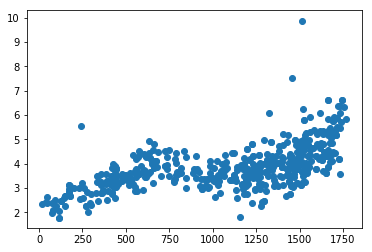

In [5]:
plt.scatter(data.time, data.danjia)

## 3. 划分训练测试集并初始化训练测试数据

In [7]:
train_size = int(np.floor(len(data) * 0.7))
#获得训练数据
train_data = data[['time', 'mianji','louceng','danjia']].iloc[:train_size, :]
test_data = data[['time', 'mianji','louceng','danjia']].iloc[train_size:, :]
train_data.shape, test_data.shape

((361, 4), (156, 4))

In [8]:
from sklearn.preprocessing import minmax_scale
# 训练数据和标签，训练
train_x = minmax_scale(train_data.values[:, :-1], axis=0)
train_y = minmax_scale(train_data.values[:, -1].reshape((-1, 1)), axis=0).squeeze()
test_x = minmax_scale(test_data.values[:, :-1], axis=0)
test_y = minmax_scale(test_data.values[:, -1].reshape((-1, 1)), axis=0).squeeze()
print('train shape', train_x.shape, train_y.shape)
print('test shape', test_x.shape, test_y.shape)

train shape (361, 3) (361,)
test shape (156, 3) (156,)


train_data.shape (361, 4)


,time,mianji,louceng,danjia
cjshijian,,,,
2015-12-05,1434,73.0,21.0,5.17
2015-12-08,1437,79.0,14.0,4.01
2015-12-08,1437,79.0,14.0,4.01
2015-12-09,1438,125.0,29.0,3.26
2015-12-12,1441,70.0,16.0,3.28
2015-12-15,1444,118.0,16.0,2.76
2015-12-15,1444,118.0,16.0,2.76
2015-12-19,1448,110.0,29.0,3.81
2015-12-19,1448,92.0,13.0,4.39


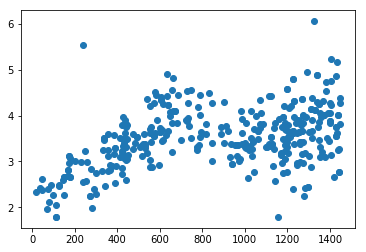

In [94]:
# # 训练数据可视化展示，可以看出单价随时间有一个变化的趋势，需要借助其他特征进行更好的拟合
# data = train_data[['time', 'danjia']]
# plt.scatter(data.time, data.danjia)
# plt.savefig('./fangjia_time.png', bbox_inchs='tight', quality=95)
# # 训练数据的数量
# print('train_data.shape',train_data.shape)
# # 部分训练数据展示
# train_data.tail(10)

In [95]:
# from sklearn.preprocessing import minmax_scale
# # 训练数据和标签，训练
# train_x = minmax_scale(train_data.values[:, :-1], axis=0)
# train_y = minmax_scale(train_data.values[:, -1].reshape((-1, 1)), axis=0).squeeze()
# test_x = minmax_scale(test_data.values[:, :-1], axis=0)
# test_y = minmax_scale(test_data.values[:, -1].reshape((-1, 1)), axis=0).squeeze()
# print('train shape', train_x.shape, train_y.shape)
# print('test shape', test_x.shape, test_y.shape)

train shape (361, 3) (361,)
test shape (156, 3) (156,)


## 4. 构建模型

In [98]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.optim import lr_scheduler
# 构建CNN网络
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(RNN, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.lstm1 = nn.LSTMCell(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.lstm2 = nn.LSTMCell(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(hidden_size2, 1)
        
        
    def forward(self, x):
        outputs = []
        # Set initial states
        h_t1 = torch.zeros(1, self.hidden_size1)
        c_t1 = torch.zeros(1, self.hidden_size1)
        h_t2 = torch.zeros(1, self.hidden_size2)
        c_t2 = torch.zeros(1, self.hidden_size2)
        for i in range(x.shape[0]):
            input_t = x[i, :].view(1, -1)
            h_t1, c_t1 = self.lstm1(input_t, (h_t1, c_t1))
            h_t1 = self.relu1(h_t1)
            h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2))
            h_t2 = self.relu2(h_t2)
            output = self.fc(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [101]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [537]:
# def init_weights(m):
#     if type(m) == nn.Linear:
#         torch.nn.init.xavier_uniform(m.weight)
#         m.bias.data.fill_(0.01)

# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2):
#         super(RNN, self).__init__()
#         self.hidden_size1 = hidden_size1
#         self.hidden_size2 = hidden_size2
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(hidden_size2, 1)
        
        
#     def forward(self, x):
#         outputs = []
#         # Set initial states
# #         h_t1 = torch.zeros(1, self.hidden_size1)
# #         c_t1 = torch.zeros(1, self.hidden_size1)
# #         h_t2 = torch.zeros(1, self.hidden_size2)
# #         c_t2 = torch.zeros(1, self.hidden_size2)
#         for i in range(x.shape[0]):
#             input_t = x[i, :].view(1, -1)
# #             h_t1, c_t1 = self.lstm1(input_t, (h_t1, c_t1))
# #             h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2))
#             output = self.fc1(input_t)
#             output = self.relu1(output)
#             output = self.fc2(output)
#             output = self.relu2(output)
#             output = self.fc3(output)
#             outputs.append(output)
#         outputs = torch.stack(outputs, 1).squeeze(2)
#         return outputs

$L(y_{true}, y_{pred})=(y_{true}-y_{pred})^2$

## 5. 训练

In [124]:
rnn = RNN(3, 30, 15)
rnn.apply(init_weights)


learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
num_epochs = 300

Loss = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
#     noise = torch.rand(train_x.shape) * 0.1
    output = rnn(torch.FloatTensor(train_x))
    loss = criterion(output.squeeze(), torch.FloatTensor(train_y)) +\
          (torch.std(output) - torch.std(torch.FloatTensor(train_y))) ** 2
    Loss.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print ('Epoch [%d/%d], Loss: %.4f' 
               %(epoch+1, num_epochs, loss.item()))

D:\Anaconda3_52\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch [1/300], Loss: 0.2044
Epoch [11/300], Loss: 0.1366
Epoch [21/300], Loss: 0.0766
Epoch [31/300], Loss: 0.0286
Epoch [41/300], Loss: 0.0257
Epoch [51/300], Loss: 0.0209
Epoch [61/300], Loss: 0.0213
Epoch [71/300], Loss: 0.0206
Epoch [81/300], Loss: 0.0205
Epoch [91/300], Loss: 0.0202
Epoch [101/300], Loss: 0.0201
Epoch [111/300], Loss: 0.0199
Epoch [121/300], Loss: 0.0197
Epoch [131/300], Loss: 0.0195
Epoch [141/300], Loss: 0.0193
Epoch [151/300], Loss: 0.0192
Epoch [161/300], Loss: 0.0190
Epoch [171/300], Loss: 0.0189
Epoch [181/300], Loss: 0.0188
Epoch [191/300], Loss: 0.0187
Epoch [201/300], Loss: 0.0186
Epoch [211/300], Loss: 0.0185
Epoch [221/300], Loss: 0.0184
Epoch [231/300], Loss: 0.0183
Epoch [241/300], Loss: 0.0182
Epoch [251/300], Loss: 0.0181
Epoch [261/300], Loss: 0.0180
Epoch [271/300], Loss: 0.0178
Epoch [281/300], Loss: 0.0176
Epoch [291/300], Loss: 0.0173


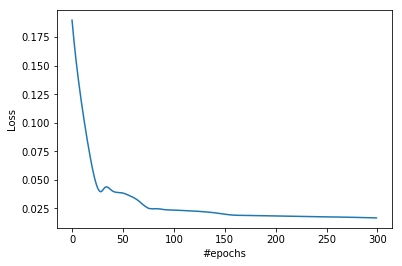

In [122]:
plt.plot(np.arange(len(Loss)), Loss)
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.savefig('./Loss-50-30.png', bbox_inches='tight', quality=95)

## 6. 测试

In [119]:
outputs = None
rnn.eval()
outputs = rnn(torch.FloatTensor(test_x))
    
# for i in list(zip(outputs.detach().squeeze().tolist(), test_y.tolist())):
#     print(i)

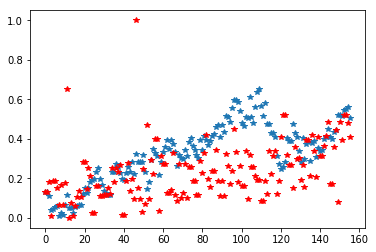

In [125]:
plt.plot(outputs.squeeze().detach().numpy(), '*')
plt.plot(test_y, 'r*')
# plt.savefig('./rnn_50-30.png', bbox_inches='tight', quality=95)
# plt.plot(outputs.detach().numpy().squeeze() - test_y, 'g')

# 二、随机森林对楼层和面积进行预测

## 1. 数据预处理和训练测试集划分

In [9]:
# 训练数据和标签，训练
train_x = train_data[['louceng', 'mianji']].values
train_y = train_data.values[:, -1].reshape((-1, 1))
test_x = test_data[['louceng', 'mianji']].values
test_y = test_data.values[:, -1].reshape((-1, 1))
print('train shape', train_x.shape, train_y.shape)
print('test shape', test_x.shape, test_y.shape)

train shape (361, 2) (361, 1)
test shape (156, 2) (156, 1)


## 2. 训练

In [10]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=30)
rfr.fit(train_x, train_y)
# mlp.fit(train_x, train_y)

D:\Anaconda3_52\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## 3. 测试

In [11]:
predict = rfr.predict(test_x)

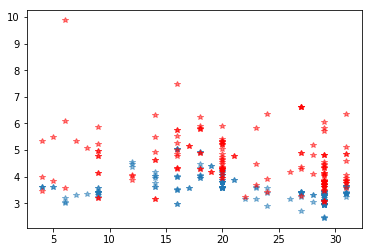

In [12]:
plt.plot(test_data.louceng, predict, '*', alpha=0.5)
plt.plot(test_data.louceng, test_y, 'r*', alpha=0.5)
plt.savefig('./rf_2.png')